# Kendall Castilla
### *This notebook will document the process of calling the Spotify API and using the retrieved data to gain insight on my listening habits.*

In [17]:
# Import necessary dependencies
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tokens import token_top_tracks
print()

## Retrieve Top Tracks

In [18]:
# Access token from https://developer.spotify.com/console/get-current-user-top-artists-and-tracks
access_token = token_top_tracks

headers = {
    'Authorization': f'Bearer {access_token}'
}

# Base url for all Spotify API calls
BASE_URL = 'https://api.spotify.com/v1/'

In [19]:
r = requests.get(f'{BASE_URL}me/top/tracks',
                 headers=headers,
                 params={
                     'limit': 100,
                     'time_range': 'short_term',
                        })
r = r.json()


In [20]:
tracks = {'id':[], 'track_title':[], 'artist':[], 'album':[], 'r_date':[]}
tracks_id = []
pos = 1
for item in r['items']:
    track_title = item['name']
    track_id = item['id']
    tracks_id.append(track_id)
    artists = []
    for i in range(0, len(item['artists'])):
        artists.append(item['artists'][i]['name'])
    artist = "/".join(artists)
    album = item['album']['name']
    r_date = item['album']['release_date']
    """print(f'{pos})\n\tTrack: "{track_title}", \n\tID: "{track_id}"\n\tArtist(s): {artist}\n\tAlbum: "{album}"\
        \n\tRelease Date: {r_date}\n')
    print('--------------------------------------------------------------------------------------\n')"""
    tracks['id'].append(track_id)
    tracks['track_title'].append(track_title)
    tracks['artist'].append(artist)
    tracks['album'].append(album)
    tracks['r_date'].append(r_date)
    pos+=1


In [21]:
df_tracks = pd.DataFrame(tracks)
df_tracks

,id,track_title,artist,album,r_date
0,1GkKi9Ps70reSiMdwq964e,Celeste,Ivy Lab,Infinite Falling Ground,2022-10-14
1,5Zn676pCI8G9AGoV3TEYdt,Jumpman,Valee/Zelooperz,VACABULAREE,2022-12-07
2,5YygzvuFs5z4l3gxBU8BGA,631,Flor Sz/JA Beatz,631,2022-06-16
3,195kWjtyEnshTm3YamGSuW,Alpina Beama,Valee,VACABULAREE,2022-12-07
4,30ZSKXP8ZZn5Xg4lJ8hIgP,PRKOSET,Flor Sz/JA Beatz,PRKOSET,2022-11-22
5,08H282luBtVpnqYDHdLrcL,Sweat Forever,Lily Konigsberg,Lily We Need to Talk Now,2021-10-29
6,5c4EuVcAXyv7yC1NzPu49o,Viaje,Flor Sz,Viaje,2021-06-16
7,1bCkl8NNCk5RIFK5Kv4knY,I Know What You Did,Seal,6: Commitment,2010-09-10
8,4dZanQgokk107J2Tvc2zWl,More,Andy Williams,Andy Williams' Greatest Hits,1970
9,0RcHoFuIdYP4c9TYM2iAJM,Cassetteshot #2,Flor Sz,Cassetteshot #2,2021-11-30


## Track Audio Features

In [22]:
ids = ','.join(tracks_id)

In [23]:
r2 = requests.get(f"{BASE_URL}audio-features",
                  headers=headers,
                 params={
                     'ids':ids,
                        })
r2 = r2.json()

df_feats = pd.DataFrame(r2['audio_features'])
df_feats.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.544,0.525,3,-10.636,0,0.0336,0.326,0.894000,0.1080,0.104,120.039,audio_features,1GkKi9Ps70reSiMdwq964e,spotify:track:1GkKi9Ps70reSiMdwq964e,https://api.spotify.com/v1/tracks/1GkKi9Ps70re...,https://api.spotify.com/v1/audio-analysis/1GkK...,184213,4
1,0.597,0.483,1,-11.281,1,0.3870,0.207,0.000015,0.0969,0.374,90.012,audio_features,5Zn676pCI8G9AGoV3TEYdt,spotify:track:5Zn676pCI8G9AGoV3TEYdt,https://api.spotify.com/v1/tracks/5Zn676pCI8G9...,https://api.spotify.com/v1/audio-analysis/5Zn6...,213999,4
2,0.685,0.472,3,-9.527,0,0.2010,0.606,0.000000,0.1180,0.545,100.062,audio_features,5YygzvuFs5z4l3gxBU8BGA,spotify:track:5YygzvuFs5z4l3gxBU8BGA,https://api.spotify.com/v1/tracks/5YygzvuFs5z4...,https://api.spotify.com/v1/audio-analysis/5Yyg...,163200,4
3,0.835,0.340,11,-15.932,0,0.3190,0.167,0.000118,0.1610,0.297,132.024,audio_features,195kWjtyEnshTm3YamGSuW,spotify:track:195kWjtyEnshTm3YamGSuW,https://api.spotify.com/v1/tracks/195kWjtyEnsh...,https://api.spotify.com/v1/audio-analysis/195k...,127916,4
4,0.730,0.484,11,-8.699,0,0.0701,0.793,0.000079,0.1260,0.302,121.069,audio_features,30ZSKXP8ZZn5Xg4lJ8hIgP,spotify:track:30ZSKXP8ZZn5Xg4lJ8hIgP,https://api.spotify.com/v1/tracks/30ZSKXP8ZZn5...,https://api.spotify.com/v1/audio-analysis/30ZS...,162702,4


In [24]:
df = pd.concat([df_tracks, df_feats], axis=1)
df.drop(['id', 'type', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)
df.head()

,track_title,artist,album,r_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Celeste,Ivy Lab,Infinite Falling Ground,2022-10-14,0.544,0.525,3,-10.636,0,0.0336,0.326,0.894000,0.1080,0.104,120.039,184213,4
1,Jumpman,Valee/Zelooperz,VACABULAREE,2022-12-07,0.597,0.483,1,-11.281,1,0.3870,0.207,0.000015,0.0969,0.374,90.012,213999,4
2,631,Flor Sz/JA Beatz,631,2022-06-16,0.685,0.472,3,-9.527,0,0.2010,0.606,0.000000,0.1180,0.545,100.062,163200,4
3,Alpina Beama,Valee,VACABULAREE,2022-12-07,0.835,0.340,11,-15.932,0,0.3190,0.167,0.000118,0.1610,0.297,132.024,127916,4
4,PRKOSET,Flor Sz/JA Beatz,PRKOSET,2022-11-22,0.730,0.484,11,-8.699,0,0.0701,0.793,0.000079,0.1260,0.302,121.069,162702,4


In [25]:
from datetime import datetime

df.r_date = df.r_date.apply(lambda x: x[:7])
df.head()

,track_title,artist,album,r_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Celeste,Ivy Lab,Infinite Falling Ground,2022-10,0.544,0.525,3,-10.636,0,0.0336,0.326,0.894000,0.1080,0.104,120.039,184213,4
1,Jumpman,Valee/Zelooperz,VACABULAREE,2022-12,0.597,0.483,1,-11.281,1,0.3870,0.207,0.000015,0.0969,0.374,90.012,213999,4
2,631,Flor Sz/JA Beatz,631,2022-06,0.685,0.472,3,-9.527,0,0.2010,0.606,0.000000,0.1180,0.545,100.062,163200,4
3,Alpina Beama,Valee,VACABULAREE,2022-12,0.835,0.340,11,-15.932,0,0.3190,0.167,0.000118,0.1610,0.297,132.024,127916,4
4,PRKOSET,Flor Sz/JA Beatz,PRKOSET,2022-11,0.730,0.484,11,-8.699,0,0.0701,0.793,0.000079,0.1260,0.302,121.069,162702,4


## Plots/Machine Learning

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
df_1 = df[['track_title', 'energy', 'tempo']].sort_values('energy', axis=0)
df_1.head()

,track_title,energy,tempo
49,Yesterdays,0.0583,86.838
39,On the Cusp,0.0913,85.499
42,Days of Wine and Roses,0.1140,84.602
25,In a Minute,0.1430,99.003
19,Dripping,0.1570,93.506


<AxesSubplot:xlabel='energy', ylabel='tempo'>

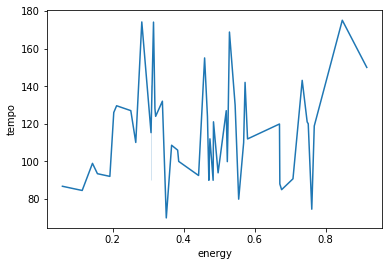

In [28]:
sns.lineplot(data = df_1,
               x = 'energy',
               y = 'tempo')

In [29]:
keymap = {0:'C', 1:'C#', 2:'D', 3:'D#/Eb', 4:'E', 5:'F', 6:'F#/Gb', 
          7:'G', 8:'G#/Ab', 9:'A', 10:'A#/Bb', 11:'B', 12:'C'}
modemap = {0:'minor', 1:'Major'}
df['key-mode'] = df['key'].apply(lambda x: keymap[x]) + '-' + df['mode'].apply(lambda x: modemap[x])
keymode = ['key', 'mode', 'key-mode']
df[keymode].head()

,key,mode,key-mode
0,3,0,D#/Eb-minor
1,1,1,C#-Major
2,3,0,D#/Eb-minor
3,11,0,B-minor
4,11,0,B-minor


In [30]:
df_2 = df.groupby(by=['artist'])
df_2